In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np


In [62]:
spam_df = pd.read_csv("../data/spam.csv", encoding="latin-1")
spam_df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [63]:
spam_df['class'] = spam_df['Category'].apply(
    lambda row: 0 if row == "ham" else 1)

spam_df.head()

,Category,Message,class
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [64]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(spam_df['Message']).toarray()
y = spam_df['class']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [66]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [67]:
## RNN Model

class SpamRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.softmax(out)
        return out
    
        

In [68]:
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 2
num_layers = 1
learning_rate = 0.01
epochs = 100

In [69]:
model = SpamRNN(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [70]:
train_losses = []
accuracies = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model.eval()
    with torch.inference_mode():
        predictions = torch.argmax(model(X_test), axis=1)
        acc = accuracy_score(y_test, predictions)
        accuracies.append(acc)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

Epoch: 1/100, Loss: 0.7007, Accuracy: 0.8744
Epoch: 11/100, Loss: 0.3770, Accuracy: 0.9363
Epoch: 21/100, Loss: 0.3235, Accuracy: 0.9794
Epoch: 31/100, Loss: 0.3188, Accuracy: 0.9848
Epoch: 41/100, Loss: 0.3166, Accuracy: 0.9865
Epoch: 51/100, Loss: 0.3155, Accuracy: 0.9857
Epoch: 61/100, Loss: 0.3148, Accuracy: 0.9848
Epoch: 71/100, Loss: 0.3146, Accuracy: 0.9848
Epoch: 81/100, Loss: 0.3146, Accuracy: 0.9848
Epoch: 91/100, Loss: 0.3146, Accuracy: 0.9848


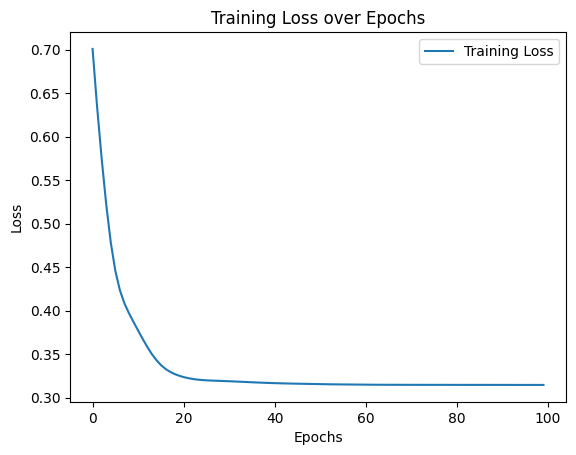

In [71]:
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

In [72]:
model.eval()
with torch.inference_mode():
    predictions = torch.argmax(model(X_test), axis=1)
    print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [73]:
def predict_message(message: str):
    message_vec = vectorizer.transform([message]).toarray()
    message_tensor = torch.tensor(message_vec, dtype=torch.float)
    
    model.eval()
    with torch.inference_mode():
        output = model(message_tensor)
        prediction = torch.argmax(output, axis=1)
    return "Spam" if prediction.item() == 1 else "Not Spam"

messages_list = ["Won 1000$", "Hello there"]

for message in messages_list:
    print(message, "->>")
    print(predict_message(message))
    print()

Won 1000$ ->>
Spam

Hello there ->>
Not Spam



In [ ]:
import pathlib
import pickle
import json


path_save = pathlib.Path("models")
path_save.mkdir(exist_ok=True)

torch.save(model.state_dict(), f"{path_save}/spam_model_rnn.pth")


with open(f"{path_save}/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
    

artifact_json = {
    "input_dim": X_train.shape[1],
    "hidden_dim": hidden_dim,
    "output_dim": output_dim,
    "num_layers": num_layers
}


with open(f"{path_save}/artifact.json", "w") as f:
    json.dump(artifact_json, f)
